# BGS Signal-to-Noise Ratio and Redshift Efficiency

Simulation 1:
* Nominal exposure time (300 sec)
* Fixed r mag (19.5)
* Redshift range 0.2+/-0.05
* Fixed moon zenith (30 deg)
* Fixed moon angle (50 deg)
* Vary moon fraction (phase) (0-1)


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
import seaborn as sns

In [2]:
import multiprocessing
nproc = multiprocessing.cpu_count() // 2 

In [3]:
from desisim.scripts.quickspectra import sim_spectra
from desisim.simexp import reference_conditions
from desisim.io import read_basis_templates
from desisim.templates import BGS
from desispec.io.util import write_bintable, fitsheader
from desispec.io.spectra import read_spectra
from desispec.io.zfind import read_zbest
from redrock.external.desi import rrdesi

In [4]:
from desiutil.log import get_logger
log = get_logger()

In [5]:
sns.set(style='ticks', font_scale=1.2, palette='Set1')
col = sns.color_palette()
#plt.style.use('seaborn-talk')
%matplotlib inline

In [6]:
simdir = os.path.join(os.getenv('DESI_ROOT'), 'spectro', 'sim', 'bgs')

### Characterize the BGS templates.

In [7]:
bgs = BGS(minwave=3500.0)

INFO:io.py:967:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits


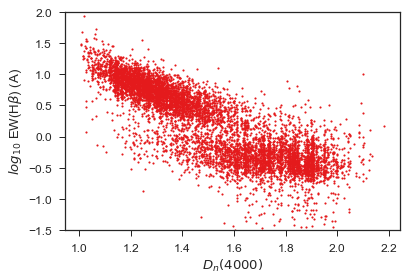

In [8]:
fig, ax = plt.subplots()
_ = ax.scatter(bgs.basemeta['D4000'], np.log10(bgs.basemeta['HBETA_EW']), s=3)
ax.set_ylim(-1.5, 2)
ax.set_xlabel(r'$D_{n}(4000)$')
ax.set_ylabel(r'$log_{10}$ EW(H$\beta$) (A)')

## Set up the simulations.

In [9]:
sim1 = dict(suffix='sim01',
            nsim=20,
            nspec=10,
            seed=111,
            rmag=19.5,
            zmean=0.2, zsig=0.05,
            moonfracmin=0.0, moonfracmax=1.0,
           )

In [10]:
program = 'bgs'
ref_obsconditions = reference_conditions[program.upper()]
ref_obsconditions

{'AIRMASS': 1.0,
 'EXPTIME': 300,
 'MOONALT': 60,
 'MOONFRAC': 0.7,
 'MOONSEP': 50,
 'SEEING': 1.1}

In [11]:
def bgs_write_simdata(sim, rand, overwrite=False):
    """Build and write a metadata table with the simulation inputs.
    
    """
    simdatafile = os.path.join(simdir, sim['suffix'], 'bgs-{}-simdata.fits'.format(sim['suffix']))
        
    cols = [
        ('SEED', 'S20'),
        ('NSPEC', 'i4'),
        ('EXPTIME', 'f4'),
        ('AIRMASS', 'f4'),
        ('SEEING', 'f4'),
        ('MOONFRAC', 'f4'),
        ('MOONSEP', 'f4'),
        ('MOONALT', 'f4')]
    simdata = Table(np.zeros(sim['nsim'], dtype=cols))
    
    simdata['EXPTIME'].unit = 's'
    simdata['SEEING'].unit = 'arcsec'
    simdata['MOONSEP'].unit = 'deg'
    simdata['MOONALT'].unit = 'deg'

    simdata['SEED'] = sim['seed']
    simdata['NSPEC'] = sim['nspec']
    simdata['AIRMASS'] = ref_obsconditions['AIRMASS']
    simdata['SEEING'] = ref_obsconditions['SEEING']
    simdata['MOONALT'] = ref_obsconditions['MOONALT']
    
    if 'moonfracmin' in sim.keys():
        simdata['MOONFRAC'] = rand.uniform(sim['moonfracmin'], sim['moonfracmax'], sim['nsim'])
    else:
        simdata['MOONFRAC'] = ref_obsconditions['MOONFRAC']

    if 'moonsepmin' in sim.keys():
        simdata['MOONSEP'] = rand.uniform(sim['moonsepmin'], sim['moonsepmax'], sim['nsim'])
    else:
        simdata['MOONSEP'] = ref_obsconditions['MOONSEP']
        
    if 'exptime' in sim.keys():
        simdata['EXPTIME'] = rand.uniform(sim['exptimmin'], sim['exptimemax'], sim['nsim'])
    else:
        simdata['EXPTIME'] = ref_obsconditions['EXPTIME']
        
    if overwrite or not os.path.isfile(simdatafile):     
        print('Writing {}'.format(simdatafile))
        write_bintable(simdatafile, simdata, extname='SIMDATA', clobber=True)
        
    return simdata

In [12]:
def simdata2obsconditions(simdata):
    obs = dict(AIRMASS=simdata['AIRMASS'], 
               EXPTIME=simdata['EXPTIME'],
               MOONALT=simdata['MOONALT'],
               MOONFRAC=simdata['MOONFRAC'],
               MOONSEP=simdata['MOONSEP'],
               SEEING=simdata['SEEING'])
    return obs

In [13]:
def bgs_sim_spectra(sim, overwrite=False):
    """Generate spectra for a given simulation with the option of overwriting files.
    
    """
    rand = np.random.RandomState(sim['seed'])
    
    # Generate the rest-frame templates.  Note that we're generating the *same* spectra
    # and only varying the observing conditions.
    redshift = rand.normal(loc=sim['zmean'], scale=sim['zsig'], size=sim['nspec'])
    rmag = rand.uniform(sim['rmag'], sim['rmag'], size=sim['nspec'])
    #rmag = rand.uniform(sim['rmin'], sim['rmax'], size=sim['nspec'])
    flux, wave, meta = bgs.make_templates(nmodel=sim1['nspec'], redshift=redshift, 
                                          mag=rmag, seed=sim['seed'])
    metadatafile = os.path.join(simdir, sim['suffix'], 'bgs-{}-metadata.fits'.format(sim['suffix']))
    if overwrite or not os.path.isfile(metadatafile):    
        print('Writing {}'.format(metadatafile))
        write_bintable(metadatafile, meta, extname='METADATA', clobber=True,
                       header=fitsheader(dict(SIM = (sim['suffix'], 'simulation number'))))
    
    # Generate the list of observing conditions dictionaries.
    simdata = bgs_write_simdata(sim, rand, overwrite=overwrite)

    for ii, simdata1 in enumerate(simdata):
        obs = simdata2obsconditions(simdata1)
        print(obs)
        spectrafile = os.path.join(simdir, sim['suffix'], 'bgs-{}-{:03}.fits'.format(sim['suffix'], ii))
        if overwrite or not os.path.isfile(spectrafile):
            sim_spectra(wave, flux[:10, :], program, spectrafile, obsconditions=obs, 
                        sourcetype='bgs', seed=sim['seed'], expid=ii)
        else:
            print('File {} exists...skipping.'.format(spectrafile))

## Generate the spectra.

In [14]:
for sim in np.atleast_1d(sim1):
    bgs_sim_spectra(sim, overwrite=True)

Writing /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-metadata.fits
Writing /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-simdata.fits
{'MOONFRAC': 0.79396256047962843, 'SEEING': 1.1, 'MOONALT': 60.0, 'MOONSEP': 50.0, 'EXPTIME': 300.0, 'AIRMASS': 1.0}
INFO:quickspectra.py:47:sim_spectra: Starting simulation of 10 spectra


DEBUG:simexp.py:379:simulate_spectra: loading specsim desi config
DEBUG:simexp.py:383:simulate_spectra: creating specsim desi simulator
DEBUG:specsim.py:39:get_simulator: Creating new  Simulator
INFO:simexp.py:404:simulate_spectra: MJD not in obsconditions, using DATE-OBS 2009-06-18T12:00:00.000
DEBUG:simexp.py:408:simulate_spectra: obsconditions MOONFRAC = 0.7939625604796284
DEBUG:simexp.py:408:simulate_spectra: obsconditions SEEING = 1.100000023841858
DEBUG:simexp.py:408:simulate_spectra: obsconditions MOONALT = 60.0
DEBUG:simexp.py:408:simulate_spectra: obsconditions MOONSEP = 50.0
DEBUG:simexp.py:408:simulate_spectra: obsconditions EXPTIME = 300.0
DEBUG:simexp.py:408:simulate_spectra: obsconditions AIRMASS = 1.0
DEBUG:simexp.py:611:get_source_types: bgs 10 targets
DEBUG:simexp.py:449:simulate_spectra: running simulation with fastsim fiber loss method
DEBUG:simexp.py:455:simulate_spectra: source types: 10 bgs


/usr/local/anaconda3/envs/desi/lib/python3.5/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


INFO:quickspectra.py:183:sim_spectra: Wrote /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-000.fits
{'MOONFRAC': 0.84056964872428119, 'SEEING': 1.1, 'MOONALT': 60.0, 'MOONSEP': 50.0, 'EXPTIME': 300.0, 'AIRMASS': 1.0}
INFO:quickspectra.py:47:sim_spectra: Starting simulation of 10 spectra
DEBUG:quickspectra.py:51:sim_spectra: sourcetype = bgs
DEBUG:simexp.py:379:simulate_spectra: loading specsim desi config
DEBUG:simexp.py:383:simulate_spectra: creating specsim desi simulator
DEBUG:specsim.py:39:get_simulator: Creating new  Simulator
INFO:simexp.py:404:simulate_spectra: MJD not in obsconditions, using DATE-OBS 2009-06-18T12:00:00.000
DEBUG:simexp.py:408:simulate_spectra: obsconditions MOONFRAC = 0.8405696487242812
DEBUG:simexp.py:408:simulate_spectra: obsconditions SEEING = 1.100000023841858
DEBUG:simexp.py:408:simulate_spectra: obsconditions MOONALT = 60.0
DEBUG:simexp.py:408:simulate_spectra: obsconditions MOONSEP = 50.0
DEBUG:simexp.py:408:simulate_spectra: obsconditions EXP

DEBUG:simexp.py:455:simulate_spectra: source types: 10 bgs
INFO:quickspectra.py:183:sim_spectra: Wrote /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-006.fits
{'MOONFRAC': 0.027447959813153733, 'SEEING': 1.1, 'MOONALT': 60.0, 'MOONSEP': 50.0, 'EXPTIME': 300.0, 'AIRMASS': 1.0}
INFO:quickspectra.py:47:sim_spectra: Starting simulation of 10 spectra
DEBUG:quickspectra.py:51:sim_spectra: sourcetype = bgs
DEBUG:simexp.py:379:simulate_spectra: loading specsim desi config
DEBUG:simexp.py:383:simulate_spectra: creating specsim desi simulator
DEBUG:specsim.py:39:get_simulator: Creating new  Simulator
INFO:simexp.py:404:simulate_spectra: MJD not in obsconditions, using DATE-OBS 2009-06-18T12:00:00.000
DEBUG:simexp.py:408:simulate_spectra: obsconditions MOONFRAC = 0.027447959813153733
DEBUG:simexp.py:408:simulate_spectra: obsconditions SEEING = 1.100000023841858
DEBUG:simexp.py:408:simulate_spectra: obsconditions MOONALT = 60.0
DEBUG:simexp.py:408:simulate_spectra: obsconditions MOONSEP 

DEBUG:simexp.py:611:get_source_types: bgs 10 targets
DEBUG:simexp.py:449:simulate_spectra: running simulation with fastsim fiber loss method
DEBUG:simexp.py:455:simulate_spectra: source types: 10 bgs
INFO:quickspectra.py:183:sim_spectra: Wrote /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-012.fits
{'MOONFRAC': 0.27422729544851199, 'SEEING': 1.1, 'MOONALT': 60.0, 'MOONSEP': 50.0, 'EXPTIME': 300.0, 'AIRMASS': 1.0}
INFO:quickspectra.py:47:sim_spectra: Starting simulation of 10 spectra
DEBUG:quickspectra.py:51:sim_spectra: sourcetype = bgs
DEBUG:simexp.py:379:simulate_spectra: loading specsim desi config
DEBUG:simexp.py:383:simulate_spectra: creating specsim desi simulator
DEBUG:specsim.py:39:get_simulator: Creating new  Simulator
INFO:simexp.py:404:simulate_spectra: MJD not in obsconditions, using DATE-OBS 2009-06-18T12:00:00.000
DEBUG:simexp.py:408:simulate_spectra: obsconditions MOONFRAC = 0.274227295448512
DEBUG:simexp.py:408:simulate_spectra: obsconditions SEEING = 1.100000

DEBUG:simexp.py:408:simulate_spectra: obsconditions EXPTIME = 300.0
DEBUG:simexp.py:408:simulate_spectra: obsconditions AIRMASS = 1.0
DEBUG:simexp.py:611:get_source_types: bgs 10 targets
DEBUG:simexp.py:449:simulate_spectra: running simulation with fastsim fiber loss method
DEBUG:simexp.py:455:simulate_spectra: source types: 10 bgs
INFO:quickspectra.py:183:sim_spectra: Wrote /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-018.fits
{'MOONFRAC': 0.72784909650152341, 'SEEING': 1.1, 'MOONALT': 60.0, 'MOONSEP': 50.0, 'EXPTIME': 300.0, 'AIRMASS': 1.0}
INFO:quickspectra.py:47:sim_spectra: Starting simulation of 10 spectra
DEBUG:quickspectra.py:51:sim_spectra: sourcetype = bgs
DEBUG:simexp.py:379:simulate_spectra: loading specsim desi config
DEBUG:simexp.py:383:simulate_spectra: creating specsim desi simulator
DEBUG:specsim.py:39:get_simulator: Creating new  Simulator
INFO:simexp.py:404:simulate_spectra: MJD not in obsconditions, using DATE-OBS 2009-06-18T12:00:00.000
DEBUG:simexp.py:

## Fit the redshifts.

In [15]:
def bgs_redshifts(sim, overwrite=False):
    """Fit for the redshifts.
    
    """
    for ii in range(sim['nsim']):
        zbestfile = os.path.join(simdir, sim['suffix'], 'bgs-{}-{:03}-zbest.fits'.format(sim['suffix'], ii))
        spectrafile = os.path.join(simdir, sim['suffix'], 'bgs-{}-{:03}.fits'.format(sim['suffix'], ii))
    
        if overwrite or not os.path.isfile(zbestfile):
            rrdesi(options=['--zbest', zbestfile, '--ncpu', str(nproc), spectrafile])
        else:
            print('File {} exists...skipping.'.format(zbestfile))    

In [16]:
for sim in np.atleast_1d(sim1):
    bgs_redshifts(sim, overwrite=True)

INFO: reading targets
INFO: reading templates
INFO: Can't find redshift range info in template file /Users/ioannis/repos/desihub/redrock/py/redrock/templates/rrtemplate-galaxy.fits, using default values
INFO: Can't find redshift range info in template file /Users/ioannis/repos/desihub/redrock/py/redrock/templates/rrtemplate-star-B.fits, using default values
INFO: Can't find redshift range info in template file /Users/ioannis/repos/desihub/redrock/py/redrock/templates/rrtemplate-qso.fits, using default values
INFO: Can't find redshift range info in template file /Users/ioannis/repos/desihub/redrock/py/redrock/templates/rrtemplate-star-A.fits, using default values
INFO: Can't find redshift range info in template file /Users/ioannis/repos/desihub/redrock/py/redrock/templates/rrtemplate-star-M.fits, using default values
INFO: Can't find redshift range info in template file /Users/ioannis/repos/desihub/redrock/py/redrock/templates/rrtemplate-star-F.fits, using default values
INFO: Can't fin

DEBUG: PID 89823 QSO fitz in 1.3 seconds
DEBUG: PID 89823 GALAXY zscan in 15.2 seconds
DEBUG: PID 89823 GALAXY fitz in 2.0 seconds
DEBUG: PID 89823 STAR:B zscan in 1.3 seconds
DEBUG: PID 89823 STAR:B fitz in 1.1 seconds
DEBUG: PID 89823 STAR:G zscan in 1.5 seconds
DEBUG: PID 89823 STAR:G fitz in 1.1 seconds
DEBUG: PID 89823 STAR:M zscan in 1.3 seconds
DEBUG: PID 89823 STAR:M fitz in 1.2 seconds
INFO: writing /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-003-zbest.fits
INFO: finished bgs-sim01-003.fits in 38.9 seconds
INFO: reading targets
INFO: reading templates
INFO: Can't find redshift range info in template file /Users/ioannis/repos/desihub/redrock/py/redrock/templates/rrtemplate-galaxy.fits, using default values
INFO: Can't find redshift range info in template file /Users/ioannis/repos/desihub/redrock/py/redrock/templates/rrtemplate-star-B.fits, using default values
INFO: Can't find redshift range info in template file /Users/ioannis/repos/desihub/redrock/py/redrock/temp

INFO: using multiprocessing with 4 cores
DEBUG: PID 89823 STAR:F zscan in 1.3 seconds
DEBUG: PID 89823 STAR:F fitz in 1.2 seconds
DEBUG: PID 89823 STAR:K zscan in 1.3 seconds
DEBUG: PID 89823 STAR:K fitz in 1.0 seconds
DEBUG: PID 89823 STAR:A zscan in 1.4 seconds
DEBUG: PID 89823 STAR:A fitz in 1.2 seconds
DEBUG: PID 89823 QSO zscan in 4.7 seconds
DEBUG: PID 89823 QSO fitz in 1.3 seconds
DEBUG: PID 89823 GALAXY zscan in 14.9 seconds
DEBUG: PID 89823 GALAXY fitz in 2.0 seconds
DEBUG: PID 89823 STAR:B zscan in 1.3 seconds
DEBUG: PID 89823 STAR:B fitz in 1.2 seconds
DEBUG: PID 89823 STAR:G zscan in 1.3 seconds
DEBUG: PID 89823 STAR:G fitz in 1.1 seconds
DEBUG: PID 89823 STAR:M zscan in 1.4 seconds
DEBUG: PID 89823 STAR:M fitz in 1.1 seconds
INFO: writing /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-007-zbest.fits
INFO: finished bgs-sim01-007.fits in 38.5 seconds
INFO: reading targets
INFO: reading templates
INFO: Can't find redshift range info in template file /Users/ioannis/r

INFO: using multiprocessing with 4 cores
DEBUG: PID 89823 STAR:F zscan in 1.5 seconds
DEBUG: PID 89823 STAR:F fitz in 1.3 seconds
DEBUG: PID 89823 STAR:K zscan in 1.5 seconds
DEBUG: PID 89823 STAR:K fitz in 1.2 seconds
DEBUG: PID 89823 STAR:A zscan in 1.4 seconds
DEBUG: PID 89823 STAR:A fitz in 1.4 seconds
DEBUG: PID 89823 QSO zscan in 4.8 seconds
DEBUG: PID 89823 QSO fitz in 1.4 seconds
DEBUG: PID 89823 GALAXY zscan in 15.9 seconds
DEBUG: PID 89823 GALAXY fitz in 2.1 seconds
DEBUG: PID 89823 STAR:B zscan in 1.5 seconds
DEBUG: PID 89823 STAR:B fitz in 1.4 seconds
DEBUG: PID 89823 STAR:G zscan in 1.7 seconds
DEBUG: PID 89823 STAR:G fitz in 1.3 seconds
DEBUG: PID 89823 STAR:M zscan in 1.5 seconds
DEBUG: PID 89823 STAR:M fitz in 1.2 seconds
INFO: writing /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-011-zbest.fits
INFO: finished bgs-sim01-011.fits in 41.9 seconds
INFO: reading targets
INFO: reading templates
INFO: Can't find redshift range info in template file /Users/ioannis/r

INFO: using multiprocessing with 4 cores
DEBUG: PID 89823 STAR:F zscan in 1.3 seconds
DEBUG: PID 89823 STAR:F fitz in 1.1 seconds
DEBUG: PID 89823 STAR:K zscan in 1.5 seconds
DEBUG: PID 89823 STAR:K fitz in 1.2 seconds
DEBUG: PID 89823 STAR:A zscan in 1.3 seconds
DEBUG: PID 89823 STAR:A fitz in 1.1 seconds
DEBUG: PID 89823 QSO zscan in 4.7 seconds
DEBUG: PID 89823 QSO fitz in 1.2 seconds
DEBUG: PID 89823 GALAXY zscan in 15.3 seconds
DEBUG: PID 89823 GALAXY fitz in 1.9 seconds
DEBUG: PID 89823 STAR:B zscan in 1.3 seconds
DEBUG: PID 89823 STAR:B fitz in 1.1 seconds
DEBUG: PID 89823 STAR:G zscan in 1.3 seconds
DEBUG: PID 89823 STAR:G fitz in 1.1 seconds
DEBUG: PID 89823 STAR:M zscan in 1.3 seconds
DEBUG: PID 89823 STAR:M fitz in 1.1 seconds
INFO: writing /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-015-zbest.fits
INFO: finished bgs-sim01-015.fits in 38.7 seconds
INFO: reading targets
INFO: reading templates
INFO: Can't find redshift range info in template file /Users/ioannis/r

INFO: using multiprocessing with 4 cores
DEBUG: PID 89823 STAR:F zscan in 1.6 seconds
DEBUG: PID 89823 STAR:F fitz in 1.4 seconds
DEBUG: PID 89823 STAR:K zscan in 1.6 seconds
DEBUG: PID 89823 STAR:K fitz in 1.4 seconds
DEBUG: PID 89823 STAR:A zscan in 1.5 seconds
DEBUG: PID 89823 STAR:A fitz in 1.3 seconds
DEBUG: PID 89823 QSO zscan in 7.7 seconds
DEBUG: PID 89823 QSO fitz in 1.5 seconds
DEBUG: PID 89823 GALAXY zscan in 33.0 seconds
DEBUG: PID 89823 GALAXY fitz in 12.1 seconds
DEBUG: PID 89823 STAR:B zscan in 2.9 seconds
DEBUG: PID 89823 STAR:B fitz in 2.0 seconds
DEBUG: PID 89823 STAR:G zscan in 2.1 seconds
DEBUG: PID 89823 STAR:G fitz in 1.8 seconds
DEBUG: PID 89823 STAR:M zscan in 2.4 seconds
DEBUG: PID 89823 STAR:M fitz in 2.3 seconds
INFO: writing /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-019-zbest.fits
INFO: finished bgs-sim01-019.fits in 77.6 seconds


## Gather the results.

In [17]:
def bgs_gather_results(sim, overwrite=False):
    """Gather all the pieces so we can make plots.
    
    """
    nspec = sim['nspec']
    nall = nspec * sim['nsim']
    
    resultfile = os.path.join(simdir, sim['suffix'], 'bgs-{}-results.fits'.format(sim['suffix']))
    if not overwrite or not os.path.isfile(resultfile):
        print('File {} exists...skipping.'.format(resultfile))        
        return
    
    cols = [
        ('EXPTIME', 'f4'),
        ('AIRMASS', 'f4'),
        ('MOONFRAC', 'f4'),
        ('MOONSEP', 'f4'),
        ('MOONALT', 'f4'),
        ('SNR_B', 'f4'),
        ('SNR_R', 'f4'),
        ('SNR_Z', 'f4'),
        ('TARGETID', 'i8'),
        ('TEMPLATEID', 'i4'),
        ('RMAG', 'f4'),
        ('D4000', 'f4'),
        ('EWHBETA', 'f4'), 
        ('ZTRUE', 'f4'), 
        ('Z', 'f4'), 
        ('ZERR', 'f4'), 
        ('ZWARN', 'f4')]
    result = Table(np.zeros(nall, dtype=cols))

    result['EXPTIME'].unit = 's'
    result['MOONSEP'].unit = 'deg'
    result['MOONALT'].unit = 'deg'
    
    # Read the simulation data table and the template metadata table.
    simdatafile = os.path.join(simdir, sim['suffix'], 'bgs-{}-simdata.fits'.format(sim['suffix']))
    simdata = Table.read(simdatafile)

    metadatafile = os.path.join(simdir, sim['suffix'], 'bgs-{}-metadata.fits'.format(sim['suffix']))
    meta = Table.read(metadatafile)
        
    for ii in range(sim['nsim']):
        # Copy over some data.
        result['EXPTIME'][nspec*ii:nspec*(ii+1)] = simdata['EXPTIME'][ii]
        result['AIRMASS'][nspec*ii:nspec*(ii+1)] = simdata['AIRMASS'][ii]
        result['MOONFRAC'][nspec*ii:nspec*(ii+1)] = simdata['MOONFRAC'][ii]
        result['MOONSEP'][nspec*ii:nspec*(ii+1)] = simdata['MOONSEP'][ii]
        result['MOONALT'][nspec*ii:nspec*(ii+1)] = simdata['MOONALT'][ii]
        
        #result['TARGETID'][nspec*ib:nspec*(ii+1)] = truth['TARGETID']
        result['TEMPLATEID'][nspec*ii:nspec*(ii+1)] = meta['TEMPLATEID']
        result['RMAG'][nspec*ii:nspec*(ii+1)] = 22.5 - 2.5*np.log10(meta['FLUX_R'])
        result['D4000'][nspec*ii:nspec*(ii+1)] = meta['D4000']
        result['EWHBETA'][nspec*ii:nspec*(ii+1)] = meta['EWHBETA']
        result['ZTRUE'][nspec*ii:nspec*(ii+1)] = meta['REDSHIFT']

        # Read the zbest file. 
        zbestfile = os.path.join(simdir, sim['suffix'], 'bgs-{}-{:03}-zbest.fits'.format(sim['suffix'], ii))
        if os.path.isfile(zbestfile):
            log.info('Reading {}'.format(zbestfile))
            zbest = read_zbest(zbestfile)
            # Assume the tables are row-ordered!
            result['Z'][nspec*ii:nspec*(ii+1)] = zbest.z
            result['ZERR'][nspec*ii:nspec*(ii+1)] = zbest.zerr
            result['ZWARN'][nspec*ii:nspec*(ii+1)] = zbest.zwarn
            
        # Finally, read the spectra to get the S/N.
        spectrafile = os.path.join(simdir, sim['suffix'], 'bgs-{}-{:03}.fits'.format(sim['suffix'], ii))
        if os.path.isfile(spectrafile):  
            log.info('Reading {}'.format(spectrafile))
            spec = read_spectra(spectrafile)
            for band in ('b','r','z'):
                for iobj in range(nspec):
                    these = np.where((spec.wave[band] > np.mean(spec.wave[band])-50) * 
                                     (spec.wave[band] < np.mean(spec.wave[band])+50) * 
                                     (spec.flux[band][iobj, :] > 0))[0]
                    result['SNR_{}'.format(band.upper())][nspec*ii+iobj] = (
                        np.median( spec.flux[band][iobj, these] * np.sqrt(spec.ivar[band][iobj, these]) ) 
                    )
                    
    log.info('Writing {}'.format(resultfile))
    write_bintable(resultfile, result, extname='RESULTS', clobber=True)

In [18]:
for sim in np.atleast_1d(sim1):
    bgs_gather_results(sim, overwrite=True)

INFO:<ipython-input-17-4fc162186700>:62:bgs_gather_results: Reading /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-000-zbest.fits
INFO:<ipython-input-17-4fc162186700>:72:bgs_gather_results: Reading /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-000.fits


INFO:<ipython-input-17-4fc162186700>:62:bgs_gather_results: Reading /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-001-zbest.fits
INFO:<ipython-input-17-4fc162186700>:72:bgs_gather_results: Reading /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-001.fits
INFO:<ipython-input-17-4fc162186700>:62:bgs_gather_results: Reading /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-002-zbest.fits
INFO:<ipython-input-17-4fc162186700>:72:bgs_gather_results: Reading /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-002.fits
INFO:<ipython-input-17-4fc162186700>:62:bgs_gather_results: Reading /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-003-zbest.fits
INFO:<ipython-input-17-4fc162186700>:72:bgs_gather_results: Reading /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-003.fits
INFO:<ipython-input-17-4fc162186700>:62:bgs_gather_results: Reading /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-004-zbest.fits
INFO:<ipython-input-17-4fc162186700>:7

## Analyze the output from each simulation.

In [19]:
def qa_dzvsz(res, pngfile=None):
    z = res['ZTRUE']
    dz = (res['Z'] - z)
    dzr = dz / (1 + z)
    s1 = (result['ZWARN'] == 0)
    s2 = (result['ZWARN'] == 0) & (np.abs(dzr) < 0.003)
    s3 = (result['ZWARN']==0) & (np.abs(dzr) >= 0.003)    
    
    fig, ax = plt.subplots()
    ax.scatter(z[s1], dz[s1], label='ZWARN==0')
    ax.scatter(z[~s1], dz[~s1], label='ZWARNG!=0')
    ax.set_ylim(-0.3, 0.3)
    ax.axhline(y=0, ls='-', color='k', alpha=0.5)
    ax.set_xlabel(r'True Redshift $z$')
    ax.set_ylabel(r'$z_{\rm DESI} - z$')
    ax.legend(loc='upper right')
    if pngfile:
        plt.savefig(pngfile)    

In [20]:
def qa_sim1(res, sim, pngfile=None):
    nobj = len(res)
    rand = np.random.RandomState(1)
    fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
    ax.scatter(res['MOONFRAC'], res['SNR_B'], label='b channel', c=col[1])
    ax.scatter(res['MOONFRAC'], res['SNR_R'], label='r channel', c=col[2])
    ax.scatter(res['MOONFRAC'], res['SNR_Z'], label='z channel', c=col[0])
    ax.set_xlabel('Object-Moon Angle (deg)')
    ax.set_ylabel(r'Signal-to-Noise Ratio (pixel$^{-1}$)')
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(0, 3)

    ax.legend(loc='upper left', labelspacing=0.25)
    ax.text(0.95, 0.7, 't = {:g} s\nr = {:g} mag\nRedshift = {:.2f}+/-{:.2f}'.format(
        res['EXPTIME'][0], res['RMAG'][0], sim['zmean'], sim['zsig'])+\
            '\nLunar Altitude = {:g} deg\nLunar Separation = {:g}'.format(
                res['MOONALT'][0], res['MOONSEP'][0]), horizontalalignment='right', 
            transform=ax.transAxes, fontsize=11)
    
    plt.subplots_adjust(bottom=0.2, right=0.95, left=0.15)
    if pngfile:
        plt.savefig(pngfile)

In [21]:
sim = sim1
resultfile = os.path.join(simdir, sim['suffix'], 'bgs-{}-results.fits'.format(sim['suffix']))
log.info('Reading {}'.format(resultfile))
result = Table.read(resultfile)

INFO:<ipython-input-21-f46db84ebda3>:3:<module>: Reading /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-results.fits


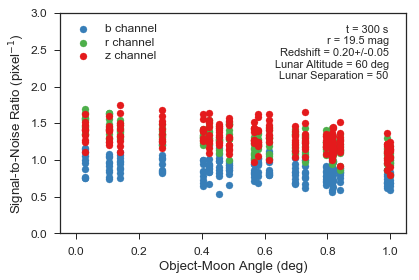

In [22]:
qa_sim1(result, sim1)

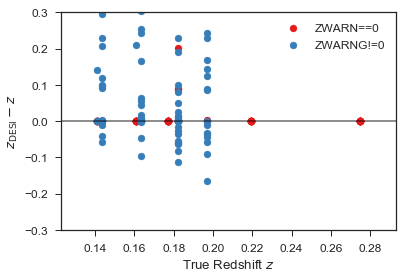

In [23]:
qa_dzvsz(result)